In [559]:
import pandas as pd
import yfinance as yf
import datetime
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing  
warnings.filterwarnings('ignore')

In [560]:
def download_stocks_history(stksybl):
    stock_final = pd.DataFrame()
    stock_symbol = stksybl 
    try:
        stock = []
        stock = yf.download(stock_symbol,period='5y')
        if len(stock) == 0:
            None
        else:
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
    fileName = 'data/'+str(stock_symbol)+'_stock.csv'
    stock_final.to_csv(fileName) # save data to a csv file for later use
    return stock_final

In [561]:
companyCode = 'WIPRO'
stocks_data = download_stocks_history(companyCode+".NS") 



[*********************100%***********************]  1 of 1 completed


In [562]:
stocks_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-12,200.850052,200.850052,195.243805,197.381302,193.033966,6198038
2017-06-13,195.000046,200.025055,192.562546,194.250046,189.971680,4473021
2017-06-14,195.975052,195.975052,189.225052,192.075043,187.844589,4040258
2017-06-15,195.000046,196.425049,191.287552,195.637543,191.328613,4158901
2017-06-16,195.075043,197.325043,189.600052,191.437546,187.221146,4015144


In [563]:
stocks_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-06,472.000000,475.500000,464.200012,473.200012,473.200012,6895578
2022-06-07,470.000000,470.750000,465.149994,467.649994,467.649994,2350671
2022-06-08,471.049988,472.000000,464.299988,470.399994,470.399994,2813826
2022-06-09,467.049988,476.149994,464.250000,475.049988,475.049988,3701119
2022-06-10,467.200012,467.200012,456.299988,460.950012,460.950012,8724208


In [564]:
stocks_data.rename(columns = {'Adj Close':'AdjClose'}, inplace = True)

In [565]:
stocks_data_copy =  stocks_data.copy()

# EDA & Data Visualization

In [566]:
def initial_EDA():
    print("Summary \n\n",stocks_data.describe())
    print("\n-------------------------------------------\n")
    print("Shape\n\n",stocks_data.shape)
    print("\n-------------------------------------------\n")
    print("Data Types\n\n",stocks_data.dtypes)
    print("\n-------------------------------------------\n")
    print("Checking Missed valued\n\n",stocks_data.isnull().sum())
    print("\n-------------------------------------------\n")
    print("Checking Duplicate Values\n\n",stocks_data.duplicated().sum())
    print("\n-------------------------------------------\n")
    print("Checking Corelation\n",stocks_data.corr())
initial_EDA()

Summary 

               Open         High          Low        Close     AdjClose  \
count  1236.000000  1236.000000  1236.000000  1236.000000  1236.000000   
mean    334.756826   338.635002   330.487474   334.393228   330.133363   
std     153.220627   154.756914   151.218629   152.805200   152.285554   
min     163.100006   171.350006   159.399994   162.350006   160.387299   
25%     221.250061   223.443760   219.300049   221.128181   217.026485   
50%     256.925003   259.250000   253.574997   256.425003   252.306389   
75%     435.924995   440.125000   428.650002   433.949997   429.667633   
max     722.750000   739.849976   716.000000   721.500000   714.380005   

             Volume  
count  1.236000e+03  
mean   7.603001e+06  
std    9.123664e+06  
min    1.900540e+05  
25%    3.434894e+06  
50%    5.289796e+06  
75%    8.394058e+06  
max    1.303676e+08  

-------------------------------------------

Shape

 (1236, 6)

-------------------------------------------

Data Types

 O

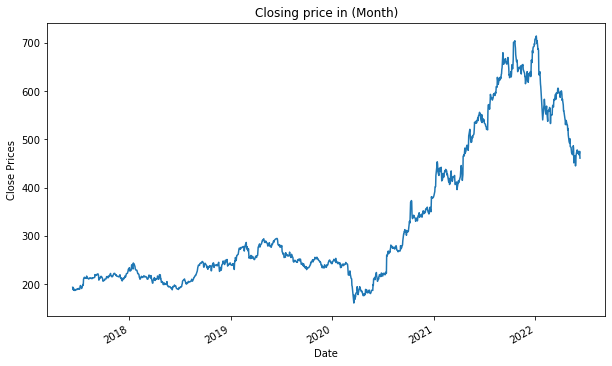

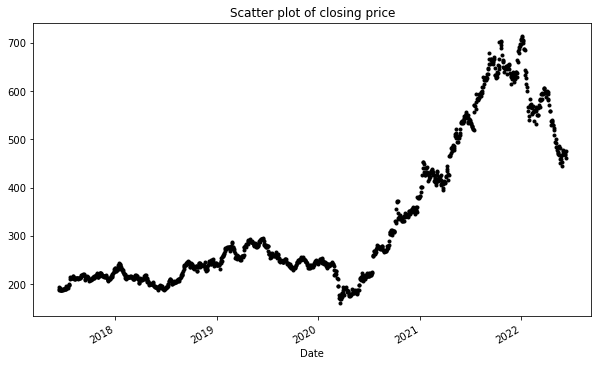

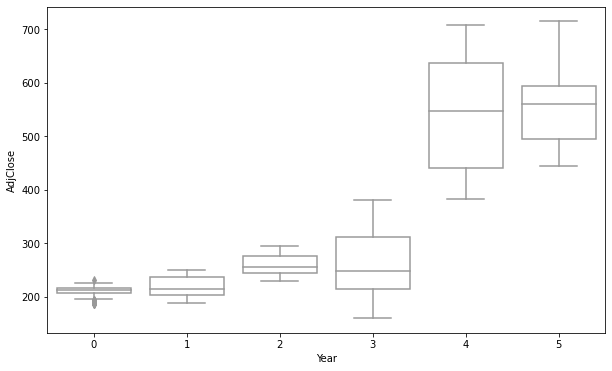

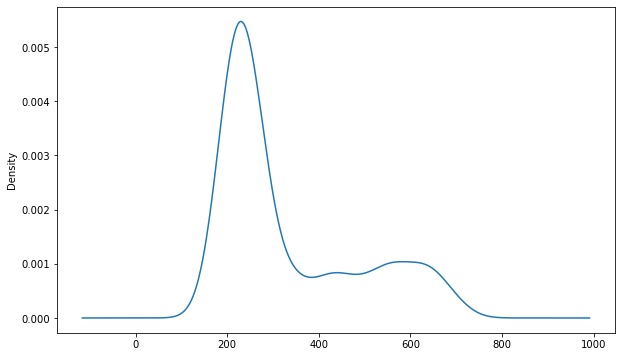

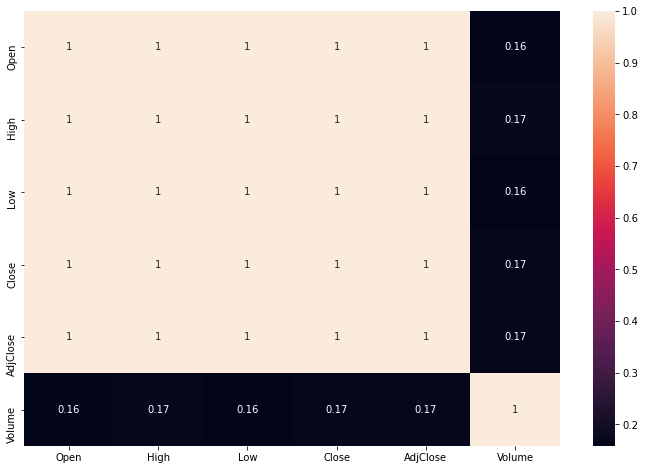

In [567]:
def plot_diagram():
    #plot close price
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Close Prices')
    plot1_df = stocks_data.groupby(["Date"])["AdjClose"].mean()
    plot1_df.plot()
    plt.title('Closing price in (Month)')
    plt.show()
    
    #scatter plot of the sales
    plt.figure(figsize=(10,6))
    df_close = stocks_data['AdjClose']
    df_close.plot(style='k.')
    plt.title('Scatter plot of closing price')
    plt.show()

    #Boxplot
    plt.figure(figsize=(10,6))
    data_boxplot = []
    for year in range(2017, 2023):
        data_boxplot.append(stocks_data.loc[(stocks_data.index.year == year)]['AdjClose'])

    import seaborn as sns
    ax = plt.gca()
    sns.boxplot(data=data_boxplot, color='w', whis=1.5)
    ax.set_xlabel('Year')
    ax.set_ylabel('AdjClose')
        
    #Distribution of the dataset
    plt.figure(figsize=(10,6))
    df_close.plot(kind='kde')
    plt.show()
    #We can observe a near-normal distribution(bell-curve) over sales values.
    
    #corelation plot
    corr = stocks_data.corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(corr,annot=True)
plot_diagram()

# Model Building

### 1.ARIMA Model Training

<AxesSubplot:ylabel='Density'>

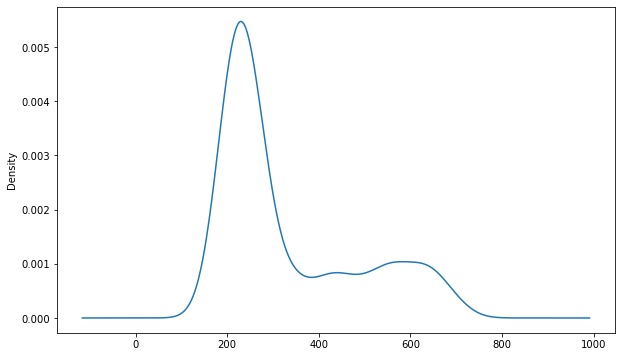

In [568]:
stocks_data['AdjClose'].plot(kind='kde')

#### Stationarity

In [569]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    print(f'Inference: Time Series is {"non" if adft[1]>=0.05 else""} stationary')


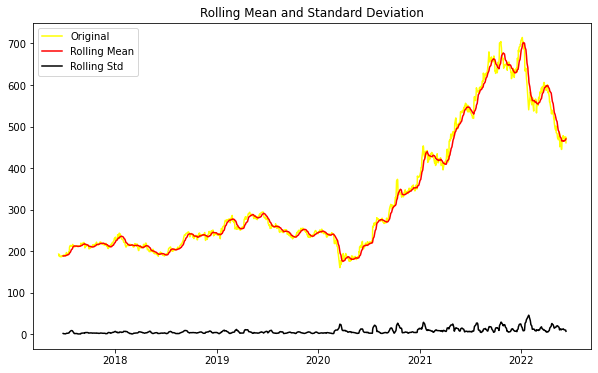

Results of dickey fuller test
Test Statistics                  -0.825478
p-value                           0.811523
No. of lags used                 19.000000
Number of observations used    1216.000000
critical value (1%)              -3.435739
critical value (5%)              -2.863920
critical value (10%)             -2.568037
dtype: float64
Inference: Time Series is non stationary


In [570]:
test_stationarity(stocks_data['AdjClose'])

### Differencing the data

#### Convert our non-stationary data to stationary data using the differencing method.

In [571]:
stock_close_diff = stocks_data['AdjClose'].diff()
stock_close_diff.dropna(inplace=True)
stock_close_diff.head()

Date
2017-06-13   -3.062286
2017-06-14   -2.127090
2017-06-15    3.484024
2017-06-16   -4.107468
2017-06-19   -0.513443
Name: AdjClose, dtype: float64

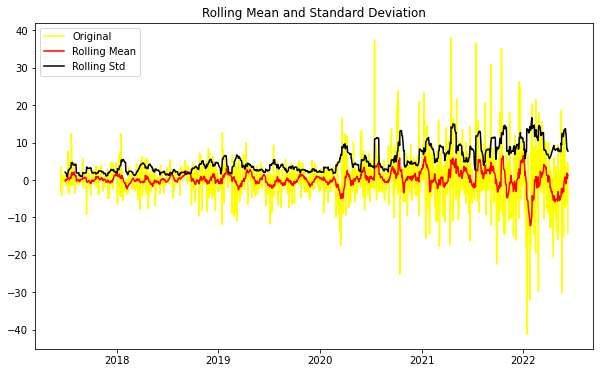

Results of dickey fuller test
Test Statistics               -8.388700e+00
p-value                        2.399121e-13
No. of lags used               1.800000e+01
Number of observations used    1.216000e+03
critical value (1%)           -3.435739e+00
critical value (5%)           -2.863920e+00
critical value (10%)          -2.568037e+00
dtype: float64
Inference: Time Series is  stationary


In [572]:
test_stationarity(stock_close_diff)

### Plotting Seasonal Differnce

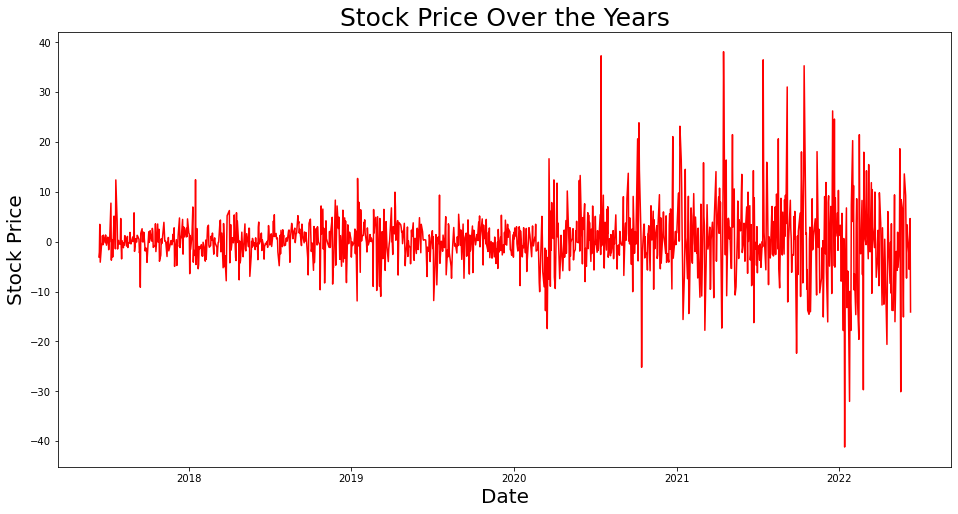

In [573]:
def decompose_data(stock_close):
    plt.figure(figsize=(16,8))
    plt.plot(stock_close, label='Close Seasonal Diff.',color='r')
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Over the Years',size=25);
decompose_data(stock_close_diff)

### Plotting the autocorrelation plot

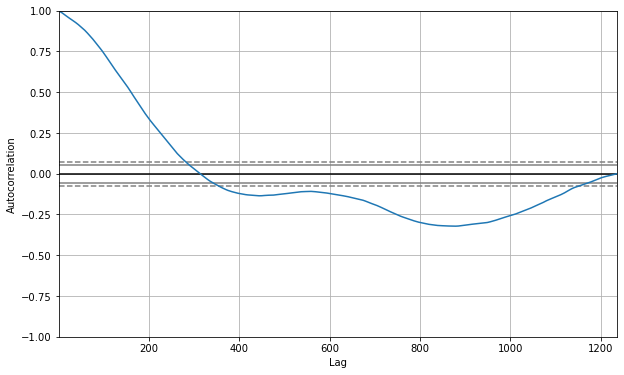

In [574]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(stocks_data['AdjClose'])
plt.show() 

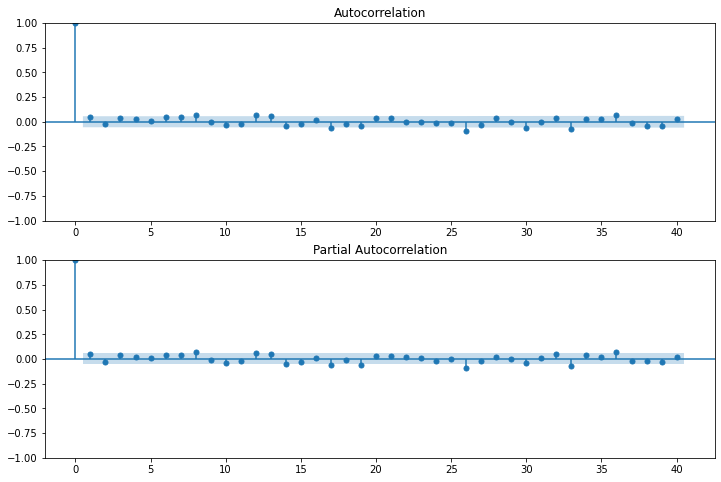

In [575]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_close_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_close_diff.dropna(),lags=40,ax=ax2)

No handles with labels found to put in legend.


Date
2017-06-12    5.262866
2017-06-13    5.246875
2017-06-14    5.235615
2017-06-15    5.253992
2017-06-16    5.232291
                ...   
2022-06-06    6.159518
2022-06-07    6.147720
2022-06-08    6.153583
2022-06-09    6.163420
2022-06-10    6.133290
Name: AdjClose, Length: 1236, dtype: float64


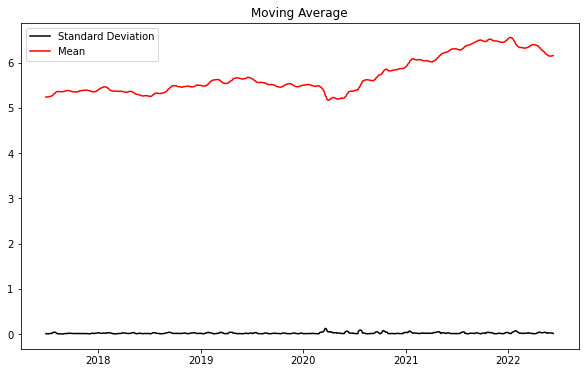

In [576]:
#if not stationary then eliminate trend Eliminate trend
from pylab import rcParams
stock_log = 0
def log_display(stock_close):
    rcParams['figure.figsize'] = 10, 6
    stock_log = np.log(stock_close)
    print(stock_log)
    moving_avg = stock_log.rolling(12).mean()
    std_dev = stock_log.rolling(12).std() 
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()
    return stock_log
stock_log = log_display(stocks_data['AdjClose'])

# Split Data into Train and Test

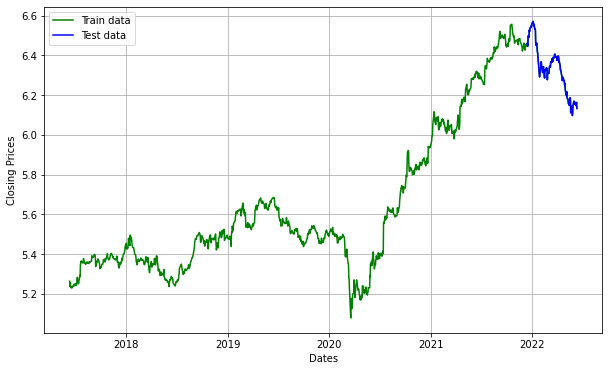

In [577]:
split_data = dict()
def split_data_fn(stk_log):
    stock_train_data, stock_test_data = stk_log[0:int(len(stk_log)*0.9)], stk_log[int(len(stk_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(stk_log, 'green', label='Train data')
    plt.plot(stock_test_data, 'blue', label='Test data')
    plt.legend()
    split_data["train_data"] = stock_train_data
    split_data["test_data"] = stock_test_data
    return split_data
split_data = split_data_fn(stock_log)

In [578]:
len(split_data["train_data"])

1112

In [579]:
split_data["train_data"]

Date
2017-06-12    5.262866
2017-06-13    5.246875
2017-06-14    5.235615
2017-06-15    5.253992
2017-06-16    5.232291
                ...   
2021-12-06    6.427034
2021-12-07    6.439605
2021-12-08    6.454204
2021-12-09    6.456538
2021-12-10    6.448813
Name: AdjClose, Length: 1112, dtype: float64

In [580]:
lenTestData = len(split_data["test_data"])
lenTestData

124

# Performing Auto Arima

In [581]:
model_autoARIMA = 0
def create_model_autoARIMA(train_data):
    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, max_q=3, # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
    print(model_autoARIMA.summary())
    return model_autoARIMA
model_autoARIMA = create_model_autoARIMA(split_data["train_data"])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5834.652, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5832.811, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5832.802, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5832.518, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5830.693, Time=0.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.572 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1112
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2919.326
Date:                Fri, 10 Jun 2022   AIC                          -5834.652
Time:                        17:42:18   BIC                          -5824.626
Sample:                             0   HQIC                         -5830.861
                               - 1112                                  

In [582]:
bestOrder = model_autoARIMA.order
bestOrder

(0, 1, 0)

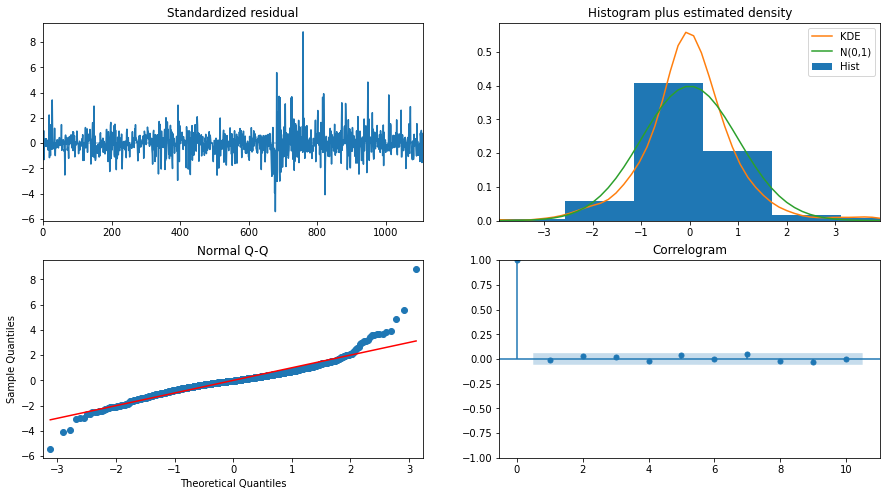

In [583]:
def plot_model_autoARIMA():
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()
plot_model_autoARIMA()

In [584]:
fitted=0
def create_final_model(train_data):
    fitted = model_autoARIMA.fit(train_data)
    print(fitted.summary())
    return fitted
fitted = create_final_model(split_data["train_data"])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1112
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2919.326
Date:                Fri, 10 Jun 2022   AIC                          -5834.652
Time:                        17:42:19   BIC                          -5824.626
Sample:                             0   HQIC                         -5830.861
                               - 1112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.959      0.050   -6.44e-07       0.002
sigma2         0.0003   5.82e-06     52.495      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.16   Jarque-

### ARIMA - Prediction

In [585]:
split_data['train_data'].tail()

Date
2021-12-06    6.427034
2021-12-07    6.439605
2021-12-08    6.454204
2021-12-09    6.456538
2021-12-10    6.448813
Name: AdjClose, dtype: float64

In [586]:
predictArima = model_autoARIMA.predict(n_periods=lenTestData)
predictArima = pd.DataFrame(predictArima,index = split_data["test_data"].index,columns=['Prediction'])

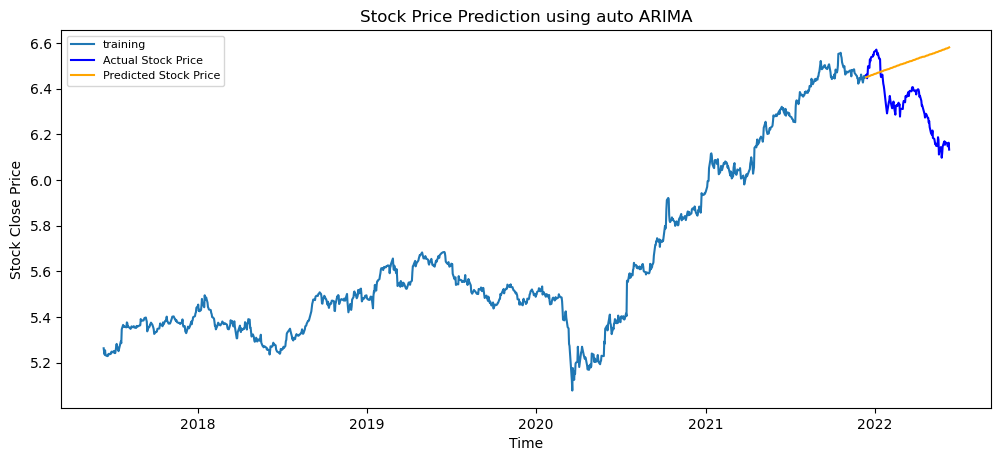

In [587]:
def plot_arima_forecasting(split_data):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(split_data["train_data"], label='training')
    plt.plot(split_data["test_data"], color = 'blue', label='Actual Stock Price')
    plt.plot(predictArima['Prediction'], color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction using auto ARIMA')
    plt.xlabel('Time')
    plt.ylabel('Stock Close Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
plot_arima_forecasting(split_data)

In [588]:
predictArima

,Prediction
Date,
2021-12-13,6.449880
2021-12-14,6.450948
2021-12-15,6.452015
2021-12-16,6.453083
2021-12-17,6.454150
...,...
2022-06-06,6.576908
2022-06-07,6.577975
2022-06-08,6.579043


In [589]:
# report performance
tst_data = split_data["test_data"].values.reshape(len(split_data["test_data"]),1)

arima_rmse = math.sqrt(mean_squared_error(tst_data, predictArima))
print('RMSE: '+str(arima_rmse))
arima_mape = np.mean(np.abs(predictArima - tst_data)/np.abs(tst_data))
print('MAPE: '+str(arima_mape.Prediction))

RMSE: 0.24076107007888914
MAPE: 0.032376735683078264


# LSTM Model Training

In [590]:
tmp_data = stocks_data_copy.sort_index(ascending=True, axis=0)
close_stocks_data = np.log(tmp_data["AdjClose"])

In [591]:
len(split_data["test_data"])

124

In [592]:
dataset = close_stocks_data.values
lstm_train = dataset[0:len(split_data["train_data"])]
lstm_test = dataset[len(split_data["train_data"]):]
dataset = dataset.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [593]:
x_train, y_train = [], []
for i in range(60,len(lstm_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network

In [594]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
LSTM_model.add(LSTM(units=50))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
LSTM_model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

1052/1052 - 30s - loss: 0.0023 - mean_squared_error: 0.0023


In [595]:
inputs = close_stocks_data[len(close_stocks_data) - len(lstm_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
print(inputs)
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)

[[0.95446042]
 [0.94827445]
 [0.9456633 ]
 [0.94289028]
 [0.94802385]
 [0.94857517]
 [0.95470863]
 [0.95688922]
 [0.93414351]
 [0.9193416 ]
 [0.92054416]
 [0.91356024]
 [0.91582617]
 [0.92085753]
 [0.92688698]
 [0.91529997]
 [0.92283867]
 [0.94152479]
 [0.93301648]
 [0.9394459 ]
 [0.95301879]
 [0.98759207]
 [0.98900837]
 [0.99070393]
 [0.98161083]
 [0.97620078]
 [0.96270214]
 [0.94812416]
 [0.94857517]
 [0.95152423]
 [0.93720777]
 [0.9267835 ]
 [0.93572845]
 [0.93404114]
 [0.93270875]
 [0.93393876]
 [0.9386837 ]
 [0.93878542]
 [0.93281132]
 [0.92164029]
 [0.94041013]
 [0.93924276]
 [0.94182849]
 [0.94218257]
 [0.93163068]
 [0.92398301]
 [0.92268243]
 [0.91608918]
 [0.91629952]
 [0.90007064]
 [0.90985504]
 [0.91687752]
 [0.91429885]
 [0.92683524]
 [0.92054416]
 [0.90334797]
 [0.91176319]
 [0.92153593]
 [0.92309887]
 [0.91792717]
 [0.92538472]
 [0.92693878]
 [0.91598401]
 [0.92424277]
 [0.9512249 ]
 [0.94636735]
 [0.97089213]
 [0.96588286]
 [0.97451628]
 [0.97826467]
 [0.97936593]
 [0.98

### LSTM prediction

In [596]:
LSTM_forcast = LSTM_model.predict(X_test)
LSTM_forcast = scaler.inverse_transform(LSTM_forcast)

In [597]:
tmp_dataset = LSTM_forcast.flatten()
tmp_test_data = split_data["test_data"].reset_index()
lstm_close_stocks_predictions = pd.DataFrame(index=range(0,len(tmp_dataset)),columns=['Date','Prediction'])
for i in range(0,len(tmp_dataset)):
    lstm_close_stocks_predictions['Date'][i] = tmp_test_data['Date'][i].date()
    lstm_close_stocks_predictions['Prediction'][i] = tmp_dataset[i]
    
lstm_close_stocks_predictions.set_index('Date',inplace=True)    
lstm_close_stocks_predictions


,Prediction
Date,
2021-12-13,6.52192
2021-12-14,6.52326
2021-12-15,6.5251
2021-12-16,6.52606
2021-12-17,6.52722
...,...
2022-06-06,6.21635
2022-06-07,6.21963
2022-06-08,6.2216


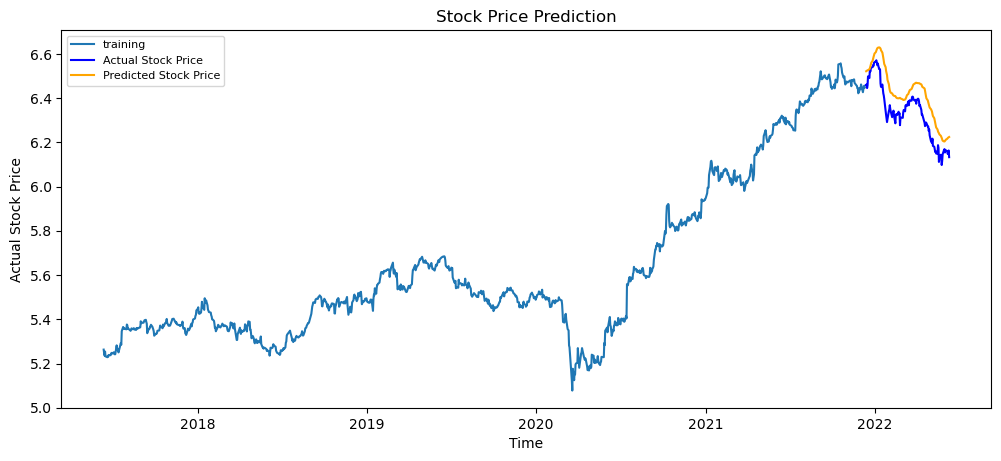

In [598]:
#for plotting
def create_lstm_forecasting(split_data):
    plt.figure(figsize=(12,5), dpi=100)
    #for plotting
    train = close_stocks_data[:len(lstm_train)]
    test = close_stocks_data[len(lstm_train):]
    lstm_Predictions = lstm_close_stocks_predictions
    plt.plot(train,label='training')
    plt.plot(test, color = 'blue', label='Actual Stock Price')
    plt.plot(lstm_Predictions, color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
create_lstm_forecasting(split_data)

In [599]:
lstm_rmse = math.sqrt(mean_squared_error(lstm_test, LSTM_forcast))
print('RMSE: '+str(lstm_rmse))
lstm_mape = np.mean(np.abs(LSTM_forcast - lstm_test)/np.abs(lstm_test))
print('MAPE: '+str(lstm_mape))

RMSE: 0.09704009188207162
MAPE: 0.02533471839093331


# Holts winter exponential smoothing with additive seasonality and additive trend

In [600]:
x = 12
alpha = 1/(2*x)

### Single exponential smoothing

<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing grpah'}, xlabel='Date'>

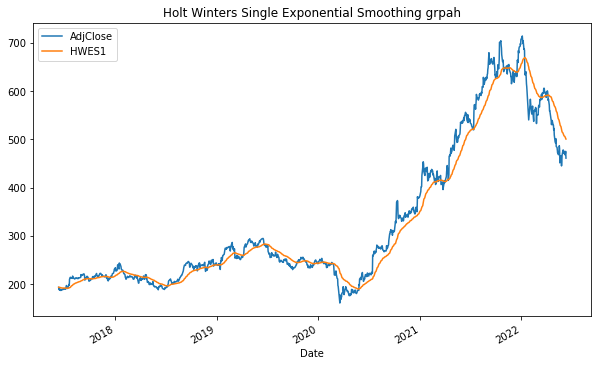

In [601]:
# Single exponential smoothing 
stocks_data['HWES1'] = SimpleExpSmoothing(stocks_data['AdjClose']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues      
stocks_data[['AdjClose','HWES1']].plot(title='Holt Winters Single Exponential Smoothing grpah')

In [602]:
stocks_data

,Open,High,Low,Close,AdjClose,Volume,HWES1
Date,,,,,,,
2017-06-12,200.850052,200.850052,195.243805,197.381302,193.033966,6198038,193.033966
2017-06-13,195.000046,200.025055,192.562546,194.250046,189.971680,4473021,193.033966
2017-06-14,195.975052,195.975052,189.225052,192.075043,187.844589,4040258,192.906371
2017-06-15,195.000046,196.425049,191.287552,195.637543,191.328613,4158901,192.695463
2017-06-16,195.075043,197.325043,189.600052,191.437546,187.221146,4015144,192.638511
...,...,...,...,...,...,...,...
2022-06-06,472.000000,475.500000,464.200012,473.200012,473.200012,6895578,505.954943
2022-06-07,470.000000,470.750000,465.149994,467.649994,467.649994,2350671,504.590154
2022-06-08,471.049988,472.000000,464.299988,470.399994,470.399994,2813826,503.050980


### Double exponential smoothing

<AxesSubplot:title={'center':'Holt Winters grapg: Additive Trend and Multiplicative Trend'}, xlabel='Date'>

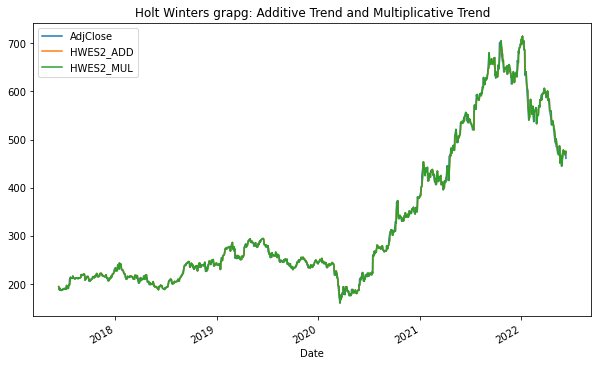

In [603]:
stocks_data['HWES2_ADD'] = ExponentialSmoothing(stocks_data['AdjClose'],trend='add').fit().fittedvalues
stocks_data['HWES2_MUL'] = ExponentialSmoothing(stocks_data['AdjClose'],trend='mul').fit().fittedvalues
stocks_data[['AdjClose','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters grapg: Additive Trend and Multiplicative Trend')

In [604]:
stocks_data

,Open,High,Low,Close,AdjClose,Volume,HWES1,HWES2_ADD,HWES2_MUL
Date,,,,,,,,,
2017-06-12,200.850052,200.850052,195.243805,197.381302,193.033966,6198038,193.033966,194.541593,194.523239
2017-06-13,195.000046,200.025055,192.562546,194.250046,189.971680,4473021,193.033966,193.239677,192.985997
2017-06-14,195.975052,195.975052,189.225052,192.075043,187.844589,4040258,192.906371,190.175492,189.921106
2017-06-15,195.000046,196.425049,191.287552,195.637543,191.328613,4158901,192.695463,188.046838,187.791822
2017-06-16,195.075043,197.325043,189.600052,191.437546,187.221146,4015144,192.638511,191.532400,191.278134
...,...,...,...,...,...,...,...,...,...
2022-06-06,472.000000,475.500000,464.200012,473.200012,473.200012,6895578,505.954943,475.716270,475.793014
2022-06-07,470.000000,470.750000,465.149994,467.649994,467.649994,2350671,504.590154,473.415040,473.489182
2022-06-08,471.049988,472.000000,464.299988,470.399994,470.399994,2813826,503.050980,467.861687,467.929282


In [605]:
# Split into train and test set
train_stocks = split_data["train_data"]
test_stocks = split_data["test_data"]

### Fit Model

In [606]:
ExponentialSmoothing_fitted_model = ExponentialSmoothing(train_stocks,trend='mul',seasonal='mul',seasonal_periods=2).fit()
Holt_forecast = ExponentialSmoothing_fitted_model.forecast(lenTestData)  # 95% conf

In [607]:
tmp_holt_dataset = np.array(Holt_forecast.values.tolist())
tmp_test_data = test_stocks.reset_index()
holt_close_stocks_predictions = pd.DataFrame(index=range(0,len(tmp_holt_dataset)),columns=['Date', 'Prediction'])
for i in range(0,len(tmp_holt_dataset)):
    holt_close_stocks_predictions['Date'][i] = tmp_test_data['Date'][i].date()
    holt_close_stocks_predictions['Prediction'][i] = tmp_holt_dataset[i]
      
    
holt_close_stocks_predictions.set_index('Date',inplace=True)    
holt_close_stocks_predictions


,Prediction
Date,
2021-12-13,6.45102
2021-12-14,6.45128
2021-12-15,6.45349
2021-12-16,6.45375
2021-12-17,6.45596
...,...
2022-06-06,6.59845
2022-06-07,6.60072
2022-06-08,6.60098


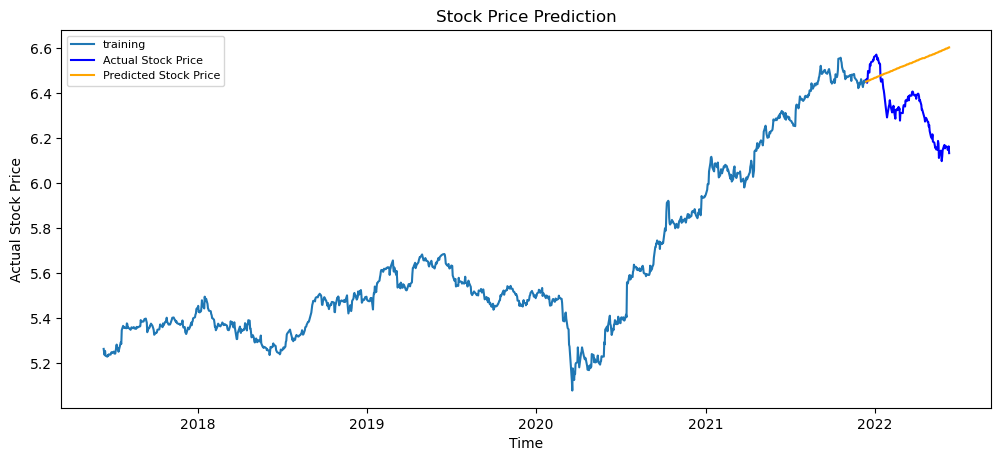

In [608]:

def create_holts_forecasting():
    plt.figure(figsize=(12,5), dpi=100)
    #for plotting
    train = close_stocks_data[:len(train_stocks)]
    test = close_stocks_data[len(train_stocks):]
    plt.plot(train_stocks,label='training')
    plt.plot(test_stocks, color = 'blue', label='Actual Stock Price')
    plt.plot(holt_close_stocks_predictions, color = 'orange',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
create_holts_forecasting()

In [609]:
holt_tst_data = np.array(test_stocks.values.tolist()) 
Holt_forecast = np.array(Holt_forecast.values.tolist())

holts_rmse = math.sqrt(mean_squared_error(holt_tst_data, Holt_forecast))
print('RMSE: '+str(holts_rmse))
holts_mape = np.mean(np.abs(Holt_forecast - holt_tst_data)/np.abs(holt_tst_data))
print('MAPE: '+str(holts_mape))

RMSE: 0.25329466105184173
MAPE: 0.03406177549779762


In [610]:
data = [[arima_rmse,arima_mape.Prediction], [lstm_rmse,lstm_mape], [holts_rmse,holts_mape]]
df = pd.DataFrame(data, columns=['RMSE','MAPE'],index=['Arima',
                               'LSTM',
                               'HOLTS'])
df

,RMSE,MAPE
Arima,0.240761,0.032377
LSTM,0.097040,0.025335
HOLTS,0.253295,0.034062


# We choose LSTM as best model for forecasting the stock time series data

#### Store model in file

In [611]:
from keras.models import load_model
fileName = 'model/model_lstm_'+companyCode+'.h5'
LSTM_model.save(fileName)  # pickle won't work for LSTM, so use this way

### Next 30 days Stocks Prediction Using LSTM

In [612]:
past_reference_data = 60 
next_future_days = 30

In [613]:
LSTM_test_data = split_data["test_data"]
len(LSTM_test_data)

124

In [614]:
x_input=LSTM_test_data[len(LSTM_test_data)-past_reference_data:].values.reshape(-1,1)
x_input = scaler.transform(x_input)
x_input = x_input.reshape(1,-1)

In [615]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [616]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=past_reference_data
i=0
while(i<next_future_days):
    
    if(len(temp_input)>past_reference_data):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = LSTM_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = LSTM_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.76740223]
61
1 day input [0.87569021 0.87898308 0.8776456  0.88876552 0.89002632 0.889314
 0.8813728  0.87786872 0.88042908 0.8785375  0.86854681 0.87965081
 0.88386451 0.88224646 0.87596018 0.86148127 0.86470054 0.85014913
 0.83545422 0.83605304 0.81092686 0.80071989 0.80831171 0.81167223
 0.80980737 0.79933021 0.79920377 0.78604737 0.79067515 0.77282454
 0.75441726 0.75000756 0.76268308 0.74089311 0.73819673 0.73053256
 0.72242508 0.72511494 0.71779877 0.71686967 0.74302863 0.73555902
 0.69232298 0.70474526 0.71400276 0.70525486 0.68290908 0.69557946
 0.71536609 0.7285676  0.73109291 0.72079174 0.72560927 0.72751255
 0.72426671 0.71636884 0.72029383 0.72687871 0.70670871 0.76740223]
1 day output [[0.770293]]
2 day input [0.87898308 0.8776456  0.88876552 0.89002632 0.889314   0.8813728
 0.87786872 0.88042908 0.8785375  0.86854681 0.87965081 0.88386451
 0.88224646 0.87596018 0.86148127 0.86470054 0.85014913 0.83545422
 0.83605304 0.81092686 0.80071989 0.80831171 0.81167223 0.8098073

12 day output [[0.8586739]]
13 day input [0.88386451 0.88224646 0.87596018 0.86148127 0.86470054 0.85014913
 0.83545422 0.83605304 0.81092686 0.80071989 0.80831171 0.81167223
 0.80980737 0.79933021 0.79920377 0.78604737 0.79067515 0.77282454
 0.75441726 0.75000756 0.76268308 0.74089311 0.73819673 0.73053256
 0.72242508 0.72511494 0.71779877 0.71686967 0.74302863 0.73555902
 0.69232298 0.70474526 0.71400276 0.70525486 0.68290908 0.69557946
 0.71536609 0.7285676  0.73109291 0.72079174 0.72560927 0.72751255
 0.72426671 0.71636884 0.72029383 0.72687871 0.70670871 0.76740223
 0.770293   0.77527577 0.78169125 0.78906459 0.7970621  0.80545676
 0.81409866 0.82289159 0.83177543 0.84071344 0.84968406 0.85867387]
13 day output [[0.86767554]]
14 day input [0.88224646 0.87596018 0.86148127 0.86470054 0.85014913 0.83545422
 0.83605304 0.81092686 0.80071989 0.80831171 0.81167223 0.80980737
 0.79933021 0.79920377 0.78604737 0.79067515 0.77282454 0.75441726
 0.75000756 0.76268308 0.74089311 0.73819673 

24 day output [[0.96643007]]
25 day input [0.80980737 0.79933021 0.79920377 0.78604737 0.79067515 0.77282454
 0.75441726 0.75000756 0.76268308 0.74089311 0.73819673 0.73053256
 0.72242508 0.72511494 0.71779877 0.71686967 0.74302863 0.73555902
 0.69232298 0.70474526 0.71400276 0.70525486 0.68290908 0.69557946
 0.71536609 0.7285676  0.73109291 0.72079174 0.72560927 0.72751255
 0.72426671 0.71636884 0.72029383 0.72687871 0.70670871 0.76740223
 0.770293   0.77527577 0.78169125 0.78906459 0.7970621  0.80545676
 0.81409866 0.82289159 0.83177543 0.84071344 0.84968406 0.85867387
 0.86767554 0.87668377 0.8856951  0.89470714 0.90371621 0.9127202
 0.92171514 0.9306981  0.9396652  0.94861227 0.95753551 0.96643007]
25 day output [[0.97529167]]
26 day input [0.79933021 0.79920377 0.78604737 0.79067515 0.77282454 0.75441726
 0.75000756 0.76268308 0.74089311 0.73819673 0.73053256 0.72242508
 0.72511494 0.71779877 0.71686967 0.74302863 0.73555902 0.69232298
 0.70474526 0.71400276 0.70525486 0.68290908 

In [617]:
day_new=np.arange(1,past_reference_data+1)
day_pred=np.arange(past_reference_data+1,past_reference_data+1+next_future_days)

In [618]:
lst_output

[[0.7674022316932678],
 [0.7702929973602295],
 [0.7752757668495178],
 [0.7816912531852722],
 [0.7890645861625671],
 [0.79706209897995],
 [0.8054567575454712],
 [0.8140986561775208],
 [0.8228915929794312],
 [0.831775426864624],
 [0.8407134413719177],
 [0.8496840596199036],
 [0.8586738705635071],
 [0.8676755428314209],
 [0.87668377161026],
 [0.8856950998306274],
 [0.8947071433067322],
 [0.9037162065505981],
 [0.9127202033996582],
 [0.9217151403427124],
 [0.9306980967521667],
 [0.9396651983261108],
 [0.9486122727394104],
 [0.9575355052947998],
 [0.9664300680160522],
 [0.9752916693687439],
 [0.9841164350509644],
 [0.99289870262146],
 [1.001634120941162],
 [1.0103185176849365]]

In [619]:
from datetime import timedelta
from datetime import date
lstm_nxt30_stocks = np.exp(scaler.inverse_transform(lst_output))
future_30days_stock_predictions = pd.DataFrame(index=range(0,next_future_days),columns=['Date', 'Prediction'])
Begindate = date.today()
for i in range(0,next_future_days):
    future_30days_stock_predictions['Date'][i] = Begindate + timedelta(days=i+1)
    future_30days_stock_predictions['Prediction'][i] = lstm_nxt30_stocks[i][0]
      
    
future_30days_stock_predictions.set_index('Date',inplace=True)    
future_30days_stock_predictions

,Prediction
Date,
2022-06-11,504.695
2022-06-12,506.88
2022-06-13,510.666
2022-06-14,515.584
2022-06-15,521.294
2022-06-16,527.559
2022-06-17,534.217
2022-06-18,541.158
2022-06-19,548.313


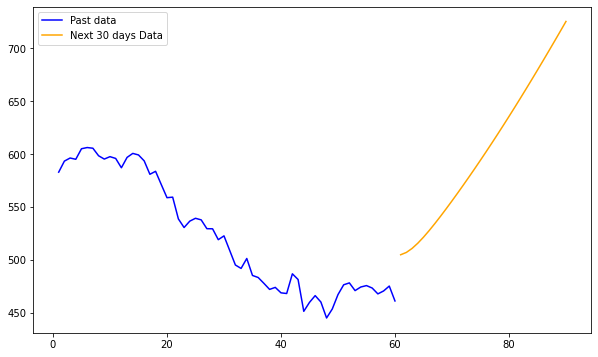

In [620]:
plt.plot(day_new,np.exp(scaler.inverse_transform(scaled_data[len(scaled_data)-past_reference_data:])),color = 'blue',label='Past data')
plt.plot(day_pred,lstm_nxt30_stocks,color = 'orange',label='Next 30 days Data')
plt.legend()
plt.show()

In [1]:
!pip install Altair